<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/training_filled_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import copy as cp
from keras.preprocessing.sequence import TimeseriesGenerator
import statistics 
from scipy.ndimage.filters import uniform_filter1d
import statistics

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

In [ ]:
from keras.layers.recurrent_v2 import LSTM

In [ ]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [ ]:
df_0 = pd.read_csv('/content/df_cov_continu_1_0.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df_0.iloc[:,3]))
df_train=df_0.iloc[0:round(N*0.8),:]
df_test=df_0.iloc[round(N*0.8):N,:]
Num_mes=14
df_comp=pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')


In [ ]:
def polynome_de_lagrange(X,Y,x):
    L_lagrange=[1]*len(X)
    for i in range(len(X)):
        for j in range(len(X)):
            if j!=i:
                L_lagrange[i]=L_lagrange[i]*(x-X[j])/(X[i]-X[j])
    poly_inter=sum([x*y for x,y in zip(L_lagrange,Y)])
    return(poly_inter)

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
def maxi_loc(X,deg):
  N=len(X)
  Max_loc=[]
  for k in range(1,N-1):
    if np.abs(X[k])>= deg*np.abs(X[k-1]) and np.abs(X[k])>=deg*np.abs(X[k+1]):
      Max_loc.append(k)
      Max_loc.append(2*X[k])
  return(Max_loc)

In [ ]:
def spectrum_take(X,freq_max):
  N=len(X)
  spectre=[0]*len(X)
  h=30/freq_max
  k1=round(len(X)/h)
  spectre[0:k1]=X[0:k1]
  spectre[len(X)-k1:len(X)]
  return(spectre)

In [ ]:
def cons_sig(sigma2,deg,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  Max_loc=maxi_loc(spectre,deg)
  new_spectre=np.zeros(len(spectre))
  mean=statistics.mean(sig)
  for k in range(round(len(Max_loc)/2)):
    new_spectre[Max_loc[2*k]]=Max_loc[2*k+1]
  periodic=np.real(np.fft.ifft(new_spectre))
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  sig_recons=sig_recons+[mean]*len(sig_recons)
  return(sig_recons)

In [ ]:
def cons_sig_2(sigma2,freq_max,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  spectrum_new=spectrum_take(spectre,freq_max)
  mean=statistics.mean(sig)
  periodic=2*np.real(np.fft.ifft(spectrum_new))-[mean]*len(spectrum_new)
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  return(sig_recons)

In [ ]:
def moyenne_nan(X):
  X=list(X)
  N=len(X)
  s=0
  n=0
  for j in range(N):
      if(np.isnan(X[j]))==True:
        continue
      else:
        s+=X[j]
        n+=1
  moyenne=s/n
  return(moyenne)   

In [ ]:
sigma2=100
mu=250
N_interpol=2
a=3
m=1.1
pois=10
expo_sc=10
bas=0
haut=100

Sigma2_mod=1.5
N_ma=10
deg=1
freq_max=0.15

In [ ]:
def create_holes(sigma2,mu,limite,a,m,pois,expo_sc,bas,haut,distrib,df_energie_rempli,N_interpol):
  Nombre_lon=len(list(df_energie_rempli.loc[:,mesure[Num_mes]]))
  df_vide=cp.deepcopy(df_energie_rempli)
  j=20
  number_of_holes=0
  if(distrib=="norm"):
    while(j<Nombre_lon-10):
      H=np.random.normal(loc=mu, scale=sigma2, size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="expo"):
    while(j<Nombre_lon-10):
      H=np.random.exponential(scale=expo_sc, size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="pareto"):
    while(j<Nombre_lon-10):
      H =(np.random.pareto(a, size=None) + 1) * m
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="poisson"):
    while(j<Nombre_lon-10):
      H=np.random.poisson(pois,size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  elif(distrib=="uniform"):
    while(j<Nombre_lon-10):
      H=np.random.uniform(low=bas, high=haut,size=None)
      H=round(abs(H))
      if(H+j<Nombre_lon):
        if(H>limite):
          j+=1
          continue
        else:
          for k in range(H):
            df_vide.iloc[j+k,2:29]=np.nan
          j+=H+round(N_interpol/2)
          number_of_holes+=H
      else:
        j+=1
        continue
  return df_vide,number_of_holes

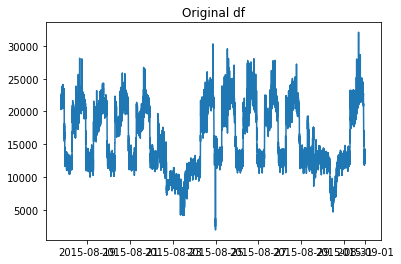

In [ ]:
plt.plot(df_comp[mesure[14]])
plt.title("Original df")
plt.show()

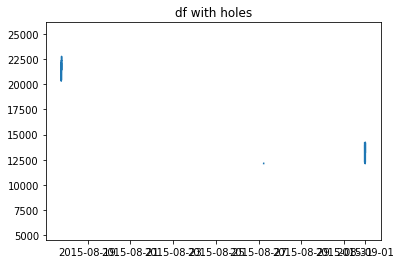

In [ ]:
df_vide,holes=create_holes(sigma2,mu,500,a,m,pois,expo_sc,bas,haut,"uniform",df_comp,N_interpol)
plt.plot(df_vide[mesure[14]])
plt.title("df with holes")
plt.show()


In [ ]:
new_df_lagrange=cp.deepcopy(df_vide)
H=list(df_vide.iloc[:,14])
Long_data=len(H)
X=list(range(N_interpol))
inv=list(reversed(list(range(1,N_interpol+1))))
j=0
while j<len(H)-round(N_interpol/2)-1:
  if np.isnan(H[j])==True:
    u=cp.deepcopy(j)
    while ((np.isnan(H[j])) and j !=len(H)-round(N_interpol/2)-1)==True:
        j+=1
    ecart=abs(u-j)
    X1=list(range(u-round(N_interpol/2),u))
    X2=list(range(u+ecart,u+ecart+round(N_interpol/2)))
    X=X1+X2
    for k in range(u,j):
      Y=[new_df_lagrange.iloc[x,Num_mes] for x in X]
      new_df_lagrange.iloc[k,Num_mes]=polynome_de_lagrange(X, Y, k)
  j+=1
  if(j==len(H)):
      break

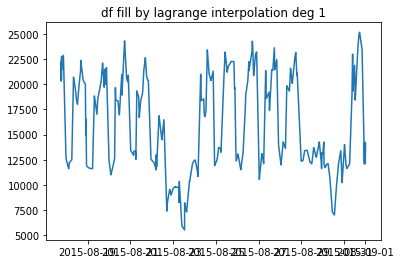

In [ ]:
plt.plot(new_df_lagrange[mesure[14]])
plt.title("df fill by lagrange interpolation deg 1")
plt.show()

In [ ]:
new_df_lagrange.isnull().sum()
p=list(new_df_lagrange.iloc[:,Num_mes])
p2=list(df_comp.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

1766.504117305732
0.08317966806394538


In [ ]:
new_df_mean=cp.deepcopy(df_vide)
H=list(df_vide.iloc[:,14])
Long_data=len(H)
moy=moyenne_nan(new_df_mean.iloc[:,Num_mes])
if(np.isnan(moy)==True):
  moy=new_df_mean.iloc[0,Num_mes]
for k in range(Long_data):
  if np.isnan(new_df_mean.iloc[k,Num_mes])==True:
    new_df_mean.iloc[k,Num_mes]=moy

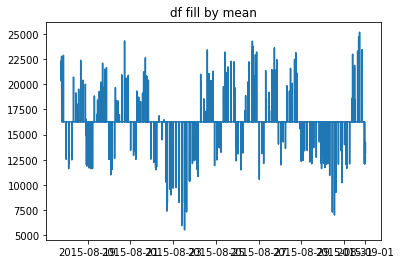

In [ ]:
plt.plot(new_df_mean[mesure[14]])
plt.title("df fill by mean")
plt.show()

In [ ]:
new_df_median=cp.deepcopy(df_vide)
H=list(df_vide.iloc[:,14])
Long_data=len(H)
median= statistics.median(new_df_median.iloc[:,Num_mes])
if(np.isnan(median)==True):
  median=new_df_median.iloc[0,Num_mes]
for k in range(Long_data):
  if np.isnan(new_df_median.iloc[k,Num_mes])==True:
    new_df_median.iloc[k,Num_mes]=median

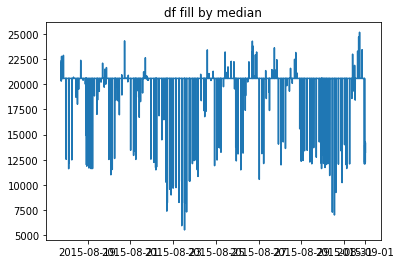

In [ ]:
plt.plot(new_df_median[mesure[14]])
plt.title("df fill by median")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
RSG_train = df_train[mesure[Num_mes]].values
scaler.fit(RSG_train.reshape(-1,1))
scaled_train = scaler.transform(RSG_train.reshape(-1,1))
n_steps=20
n_features=1
X,y=split_sequence(scaled_train,n_steps)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
X = X.reshape(X.shape[0], X.shape[1], n_features)
model.fit(X, y, epochs=50, verbose=0,batch_size=100)
new_df_cnn=cp.deepcopy(df_vide)
batch_predict=scaler.transform(np.array(new_df_cnn.iloc[:,Num_mes]).reshape(-1,1))
H=list(df_vide.iloc[:,Num_mes])
Long_data=len(H)
for j in range(19,Long_data):
  if np.isnan(new_df_cnn.iloc[j,Num_mes])==True:
    current_batch = batch_predict[j-19:j+1].reshape((1, n_steps, n_features))
    predict=model.predict(current_batch)
    batch_predict[j]=predict
    new_df_cnn.iloc[j,Num_mes]=float(scaler.inverse_transform(predict))

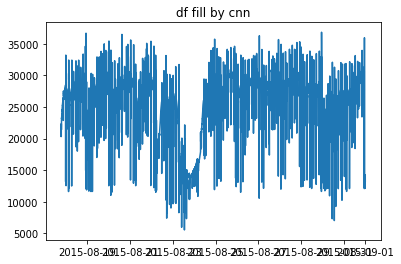

In [ ]:
plt.plot(new_df_cnn[mesure[14]])
plt.title("df fill by cnn")
plt.show()

In [ ]:
new_df_maxi_loc=cp.deepcopy(df_vide)
N_mov_av=10
extrait=list(df_0.iloc[:,Num_mes])
H=list(df_vide.iloc[:,Num_mes])
Long_data=len(H)
semaine_extraite=extrait[0:7*720]
temp1=semaine_extraite[0:165-2*720]
temp2=semaine_extraite[165-2*720:]
semaine_extraite_fin=temp2+temp1
recons_sem_1a=list(cons_sig(Sigma2_mod,deg,semaine_extraite_fin[0:5*720],N_mov_av))
recons_sem_1b=list(cons_sig(Sigma2_mod,deg,semaine_extraite_fin[5*720:],N_mov_av))
recons_sem_1=recons_sem_1a+recons_sem_1b
Q=round(Long_data/(720*7))
R=Long_data%(720*7)
recons_sig_1=recons_sem_1*Q + recons_sem_1[0:R+2]
for j in range(0,Long_data):
  if np.isnan(new_df_maxi_loc.iloc[j,Num_mes])==True:
    new_df_maxi_loc.iloc[j,Num_mes]=recons_sig_1[j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


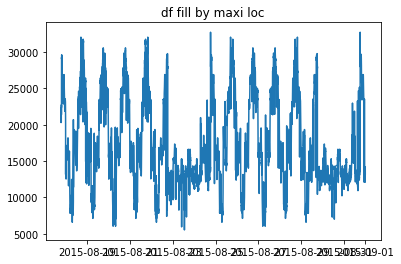

In [ ]:
plt.plot(new_df_maxi_loc[mesure[14]])
plt.title("df fill by maxi loc")
plt.show()

In [ ]:
new_df_spectrum_take=cp.deepcopy(df_vide)
extrait=list(df_0.iloc[:,Num_mes])
H=list(df_vide.iloc[:,Num_mes])
Long_data=len(H)
semaine_extraite=extrait[0:7*720]
temp1=semaine_extraite[0:165-2*720]
temp2=semaine_extraite[165-2*720:]
semaine_extraite_fin=temp2+temp1
recons_sem_2=list(cons_sig_2(Sigma2_mod,freq_max,semaine_extraite_fin,N_mov_av))
Q=round(Long_data/(720*7))
R=Long_data%(720*7)
recons_sig_2=recons_sem_2*Q + recons_sem_2[0:R+2]
for j in range(0,Long_data):
  if np.isnan(new_df_spectrum_take.iloc[j,Num_mes])==True:
    new_df_spectrum_take.iloc[j,Num_mes]=recons_sig_2[j]

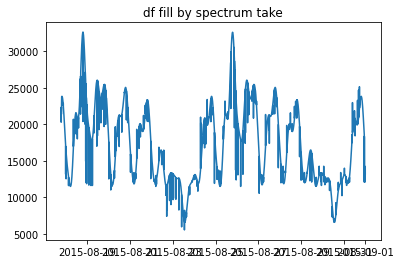

In [ ]:
plt.plot(new_df_spectrum_take[mesure[14]])
plt.title("df fill by spectrum take")
plt.show()

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
N1=len(list(df_comp.iloc[:,3]))
scaler2 = MinMaxScaler()
n_input=20

train_data=df_comp.iloc[0:round(N1*0.8),Num_mes].values
test_data=df_comp.iloc[round(N1*0.8):N1,Num_mes].values

scaler2.fit(np.reshape(train_data,(-1,1)))

train_data=np.reshape(train_data,(-1,1))
test_data=np.reshape(test_data,(-1,1))


scaled_or=scaler2.transform(train_data)
scaled_or_test=scaler2.transform(test_data)
train_generator_or=TimeseriesGenerator(scaled_or, scaled_or, length=n_input, batch_size=10)
test_generator_or=TimeseriesGenerator(scaled_or_test, scaled_or_test, length=n_input, batch_size=10)

train_data_lag=new_df_lagrange.iloc[0:round(N1*0.8),Num_mes].values
test_data_lag=new_df_lagrange.iloc[round(N1*0.8):N1,Num_mes].values
train_data_lag=np.reshape(train_data_lag,(-1,1))
test_data_lag=np.reshape(test_data_lag,(-1,1))
scaled_lag=scaler2.transform(train_data_lag)
scaled_lag_test=scaler2.transform(test_data_lag)
train_generator_lag=TimeseriesGenerator(scaled_lag, scaled_lag, length=n_input, batch_size=10)
test_generator_lag=TimeseriesGenerator(scaled_lag_test, scaled_lag_test, length=n_input, batch_size=10)

train_data_mean=new_df_mean.iloc[0:round(N1*0.8),Num_mes].values
test_data_mean=new_df_mean.iloc[round(N1*0.8):N1,Num_mes].values
train_data_mean=np.reshape(train_data_mean,(-1,1))
test_data_mean=np.reshape(test_data_mean,(-1,1))
scaled_mean=scaler2.transform(train_data_mean)
scaled_mean_test=scaler2.transform(test_data_mean)
train_generator_mean=TimeseriesGenerator(scaled_mean, scaled_mean, length=n_input, batch_size=10)
test_generator_mean=TimeseriesGenerator(scaled_mean_test, scaled_mean_test, length=n_input, batch_size=10)

train_data_median=new_df_median.iloc[0:round(N1*0.8),Num_mes].values
test_data_median=new_df_median.iloc[round(N1*0.8):N1,Num_mes].values
train_data_median=np.reshape(train_data_median,(-1,1))
test_data_median=np.reshape(test_data_median,(-1,1))
scaled_median=scaler2.transform(train_data_median)
scaled_median_test=scaler2.transform(test_data_median)
train_generator_median=TimeseriesGenerator(scaled_median, scaled_median, length=n_input, batch_size=10)
test_generator_median=TimeseriesGenerator(scaled_median_test, scaled_median_test, length=n_input, batch_size=10)

train_data_cnn=new_df_cnn.iloc[0:round(N1*0.8),Num_mes].values
test_data_cnn=new_df_cnn.iloc[round(N1*0.8):N1,Num_mes].values
train_data_cnn=np.reshape(train_data_cnn,(-1,1))
test_data_cnn=np.reshape(test_data_cnn,(-1,1))
scaled_cnn=scaler2.transform(train_data_cnn)
scaled_cnn_test=scaler2.transform(test_data_cnn)
train_generator_cnn=TimeseriesGenerator(scaled_cnn, scaled_cnn, length=n_input, batch_size=10)
test_generator_cnn=TimeseriesGenerator(scaled_cnn_test, scaled_cnn_test, length=n_input, batch_size=10)

train_data_maxi_loc=new_df_maxi_loc.iloc[0:round(N1*0.8),Num_mes].values
test_data_maxi_loc=new_df_maxi_loc.iloc[round(N1*0.8):N1,Num_mes].values
train_data_maxi_loc=np.reshape(train_data_maxi_loc,(-1,1))
test_data_maxi_loc=np.reshape(test_data_maxi_loc,(-1,1))
scaled_maxi_loc=scaler2.transform(train_data_maxi_loc)
scaled_maxi_loc_test=scaler2.transform(test_data_maxi_loc)
train_generator_maxi_loc=TimeseriesGenerator(scaled_maxi_loc, scaled_maxi_loc, length=n_input, batch_size=10)
test_generator_maxi_loc=TimeseriesGenerator(scaled_maxi_loc_test, scaled_maxi_loc_test, length=n_input, batch_size=10)

train_data_spectrum_take=new_df_spectrum_take.iloc[0:round(N1*0.8),Num_mes].values
test_data_spectrum_take=new_df_spectrum_take.iloc[round(N1*0.8):N1,Num_mes].values
train_data_spectrum_take=np.reshape(train_data_spectrum_take,(-1,1))
test_data_spectrum_take=np.reshape(test_data_spectrum_take,(-1,1))
scaled_spectrum_take=scaler2.transform(train_data_spectrum_take)
scaled_spectrum_take_test=scaler2.transform(test_data_spectrum_take)
train_generator_spectrum_take=TimeseriesGenerator(scaled_spectrum_take, scaled_spectrum_take, length=n_input, batch_size=10)
test_generator_spectrum_take=TimeseriesGenerator(scaled_spectrum_take_test, scaled_spectrum_take_test, length=n_input, batch_size=10)


In [ ]:
from keras.layers.recurrent_v2 import LSTM
# define model
model = Sequential()
model.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')

model_lag = Sequential()
model_lag.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_lag.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_lag.add(Dense(1, activation = "linear"))
model_lag.compile(loss='mse', optimizer='adam')

model_mean = Sequential()
model_mean.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_mean.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_mean.add(Dense(1, activation = "linear"))
model_mean.compile(loss='mse', optimizer='adam')

model_median = Sequential()
model_median.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_median.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_median.add(Dense(1, activation = "linear"))
model_median.compile(loss='mse', optimizer='adam')

model_cnn = Sequential()
model_cnn.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_cnn.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_cnn.add(Dense(1, activation = "linear"))
model_cnn.compile(loss='mse', optimizer='adam')

model_maxi_loc = Sequential()
model_maxi_loc.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_maxi_loc.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_maxi_loc.add(Dense(1, activation = "linear"))
model_maxi_loc.compile(loss='mse', optimizer='adam')

model_spectrum_take = Sequential()
model_spectrum_take.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=True))
model_spectrum_take.add(LSTM(30, input_shape=(n_input,1),activation='relu',return_sequences=False))
model_spectrum_take.add(Dense(1, activation = "linear"))
model_spectrum_take.compile(loss='mse', optimizer='adam')

In [ ]:
model.fit(train_generator_or,steps_per_epoch=100, epochs=20,validation_data=test_generator_or)
print("Lagrange")
model_lag.fit(train_generator_lag,steps_per_epoch=100, epochs=20,validation_data=test_generator_lag)
print("mean")
model_mean.fit(train_generator_mean,steps_per_epoch=100, epochs=20,validation_data=test_generator_mean)
print("median")
model_median.fit(train_generator_median,steps_per_epoch=100, epochs=20,validation_data=test_generator_median)
print("cnn")
model_cnn.fit(train_generator_cnn,steps_per_epoch=100, epochs=20,validation_data=test_generator_cnn)
print("maxi_loc")
model_maxi_loc.fit(train_generator_maxi_loc,steps_per_epoch=100, epochs=20,validation_data=test_generator_maxi_loc)
print("spectrum_take")
model_spectrum_take.fit(train_generator_spectrum_take,steps_per_epoch=100, epochs=20,validation_data=test_generator_spectrum_take)


Epoch 1/20
100/100 [==============================] - 5s 24ms/step - loss: 0.0669 - val_loss: 0.0058
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 4/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 8/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 10/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0028 - val_lo

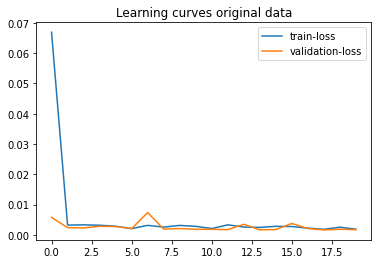

In [ ]:
loss_per_epoch = model.history.history['loss']
loss_vall=model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves original data")
plt.legend()

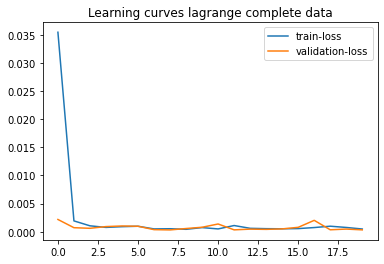

In [ ]:
loss_per_epoch = model_lag.history.history['loss']
loss_vall=model_lag.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves lagrange complete data")
plt.legend()

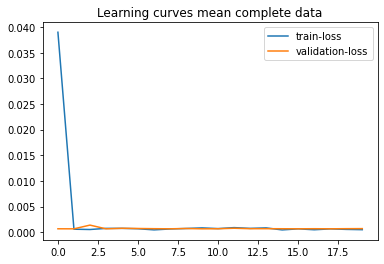

In [ ]:
loss_per_epoch = model_mean.history.history['loss']
loss_vall=model_mean.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves mean complete data")
plt.legend()

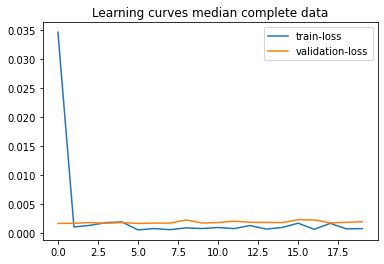

In [ ]:
loss_per_epoch = model_median.history.history['loss']
loss_vall=model_median.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves median complete data")
plt.legend()

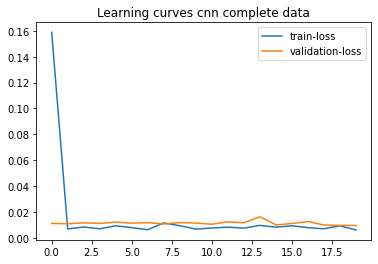

In [ ]:
loss_per_epoch = model_cnn.history.history['loss']
loss_vall=model_cnn.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves cnn complete data")
plt.legend()

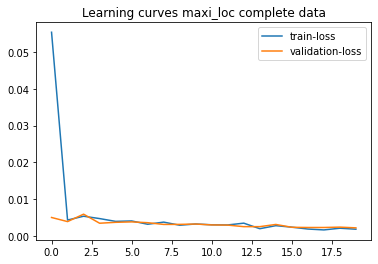

In [ ]:
loss_per_epoch = model_maxi_loc.history.history['loss']
loss_vall=model_maxi_loc.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves maxi_loc complete data")
plt.legend()

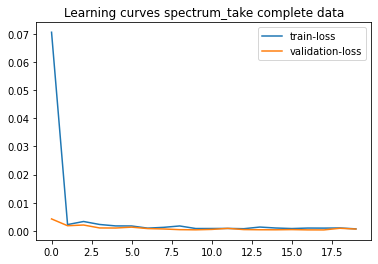

In [ ]:
loss_per_epoch = model_spectrum_take.history.history['loss']
loss_vall=model_spectrum_take.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.title("Learning curves spectrum_take complete data")
plt.legend()

In [ ]:
trainPredict = model.predict(train_generator_or)
trainPredict_lag= model_lag.predict(train_generator_or)
trainPredict_mean = model_mean.predict(train_generator_or)
trainPredict_median= model_median.predict(train_generator_or)
trainPredict_cnn= model_cnn.predict(train_generator_or)
trainPredict_maxi_loc = model_maxi_loc.predict(train_generator_or)
trainPredict_spectrum_take= model_spectrum_take.predict(train_generator_or)



true_pre=scaler2.inverse_transform(trainPredict)
true_pre_lag=scaler2.inverse_transform(trainPredict_lag)
true_pre_mean=scaler2.inverse_transform(trainPredict_mean)
true_pre_median=scaler2.inverse_transform(trainPredict_median)
true_pre_cnn=scaler2.inverse_transform(trainPredict_cnn)
true_pre_maxi_loc=scaler2.inverse_transform(trainPredict_maxi_loc)
true_pre_spectrum_take=scaler2.inverse_transform(trainPredict_spectrum_take)


In [ ]:
N=8000
Q=0
L_true=  list(df_comp[mesure[Num_mes]][n_input+1+Q:n_input+1+Q+N])
L_comp=list(df_comp[mesure[Num_mes]][n_input+1+Q:])

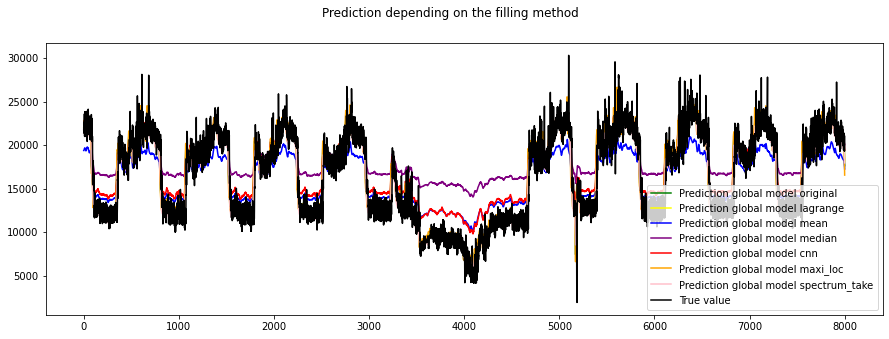

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Prediction depending on the filling method')
plt.plot(range(len(L_true)),true_pre[n_input+Q:n_input+Q+N],label='Prediction global model original',c="green")
plt.plot(range(len(L_true)),true_pre_lag[n_input+Q:n_input+Q+N],label='Prediction global model lagrange',c="yellow")
plt.plot(range(len(L_true)),true_pre_mean[n_input+Q:n_input+Q+N],label='Prediction global model mean',c="blue")
plt.plot(range(len(L_true)),true_pre_median[n_input+Q:n_input+Q+N],label='Prediction global model median',c="purple")
plt.plot(range(len(L_true)),true_pre_cnn[n_input+Q:n_input+Q+N],label='Prediction global model cnn',c="red")
plt.plot(range(len(L_true)),true_pre_maxi_loc[n_input+Q:n_input+Q+N],label='Prediction global model maxi_loc',c="orange")
plt.plot(range(len(L_true)),true_pre_spectrum_take[n_input+Q:n_input+Q+N],label='Prediction global model spectrum_take',c="pink")
plt.plot(range(len(L_true)),L_true,label='True value',c="black")
plt.legend()
plt.show()

In [ ]:
erreur_lag=np.sqrt(mean_squared_error(L_true,true_pre_lag[n_input+1+Q:n_input+1+Q+N]))
erreur_mean=np.sqrt(mean_squared_error(L_true,true_pre_mean[n_input+1+Q:n_input+1+Q+N]))
erreur_median=np.sqrt(mean_squared_error(L_true,true_pre_median[n_input+1+Q:n_input+1+Q+N]))
erreur_cnn=np.sqrt(mean_squared_error(L_true,true_pre_cnn[n_input+1+Q:n_input+1+Q+N]))
erreur_maxi_loc=np.sqrt(mean_squared_error(L_true,true_pre_maxi_loc[n_input+1+Q:n_input+1+Q+N]))
erreur_spectrum_take=np.sqrt(mean_squared_error(L_true,true_pre_spectrum_take[n_input+1+Q:n_input+1+Q+N]))
erreur_original=np.sqrt(mean_squared_error(L_true,true_pre[n_input+1+Q:n_input+1+Q+N]))
print("erreur_lag="+" "+str(erreur_lag))
print("erreur_mean="+" "+str(erreur_mean))
print("erreur_median="+" "+str(erreur_median))
print("erreur_cnn="+" "+str(erreur_cnn))
print("erreur_maxi_loc="+" "+str(erreur_maxi_loc))
print("erreur_spectrum_take="+" "+str(erreur_spectrum_take))
print("erreur_orignal_data="+" "+str(erreur_original))

erreur_lag= 1597.2908494323144
erreur_mean= 2542.8544675675307
erreur_median= 3612.9229432532857
erreur_cnn= 2206.7515335397543
erreur_maxi_loc= 1851.0063939746015
erreur_spectrum_take= 1611.164307704199
erreur_orignal_data= 1701.6946366999057
